**Motor Vehicle Crash Analysis**

Vehicle crashes are a common occurrence with sometimes deadly consequences. A statistical analysis of crash data could lead to 
better car design and improved road safety rules. This notebook shows the analysis of motor vehicle crashes in New York state 
from 2014 to 2016 inclusive. It includes results from a model to predict whether occupants of a vehicle will be injured in a 
crash. Several algorithms from two Machine Learning libraries are applied and their prediction accuracies are compared.

In [1]:
# Python packages used in analysis
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import scikit-learn utilities used
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

# Import h2o library and algorithms
import h2o
import os
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [139]:
dfv = pd.read_csv('./data/Motor_Vehicle_Crashes_-_Vehicle_Information__Three_Year_Window.csv')
dfv.shape

(1654482, 19)

In [140]:
dfi = pd.read_csv('./data/Motor_Vehicle_Crashes_-_Individual_Information__Three_Year_Window.csv')
dfi.shape

(2221172, 15)

In [141]:
# Drop duplicates in 2 input dataframes
df1 = dfv.drop_duplicates(subset=['Case Vehicle ID'])
df2 = dfi.drop_duplicates(subset=['Case Vehicle ID'])

In [142]:
# Merge 2 dataframes
df = pd.merge(df1, df2, how='inner', on='Case Vehicle ID')
df.shape

(1654468, 33)

In [143]:
# Year_x and Year_y are due to their presence in both input dataframes. Only one should be kept.
# Delete Year_y column and rename Year_x to Year
df.drop('Year_y', axis=1, inplace=True)
# Rename Year_x column
df = df.rename(columns={'Year_x': 'Year'})

In [144]:
# Number of null values in each column
print(df.isnull().sum())

Year                                      0
Case Vehicle ID                           0
Vehicle Body Type                         0
Registration Class                        0
Action Prior to Accident                  0
Type / Axles of Truck or Bus              0
Direction of Travel                       0
Fuel Type                                 0
Vehicle Year                         258498
State of Registration                135907
Number of Occupants                  191761
Engine Cylinders                     345802
Vehicle Make                         257109
Contributing Factor 1                    29
Contributing Factor 1 Description        29
Contributing Factor 2                    28
Contributing Factor 2 Description        28
Event Type                            31436
Partial VIN                          298092
Case Individual ID                        0
Victim Status                         88189
Role Type                                 0
Seating Position                

### Exploratory Analysis

In [145]:
# Dropping rows with missing values as a first step
df.dropna(inplace=True)
df.shape

(1107544, 32)

**Number of crashes by vehicle age group**

In [146]:
# Create new column with age of vehicle at time of crash
df['Vehicle Age'] = df['Year'] - df['Vehicle Year']

In [147]:
def vehicle_age_group(x):
    if x <= 20:
        return x
    elif x > 20:
        return '20+'
    else:
        return 'NaN'

df['Vehicle Age Group'] = df['Vehicle Age'].apply(vehicle_age_group)

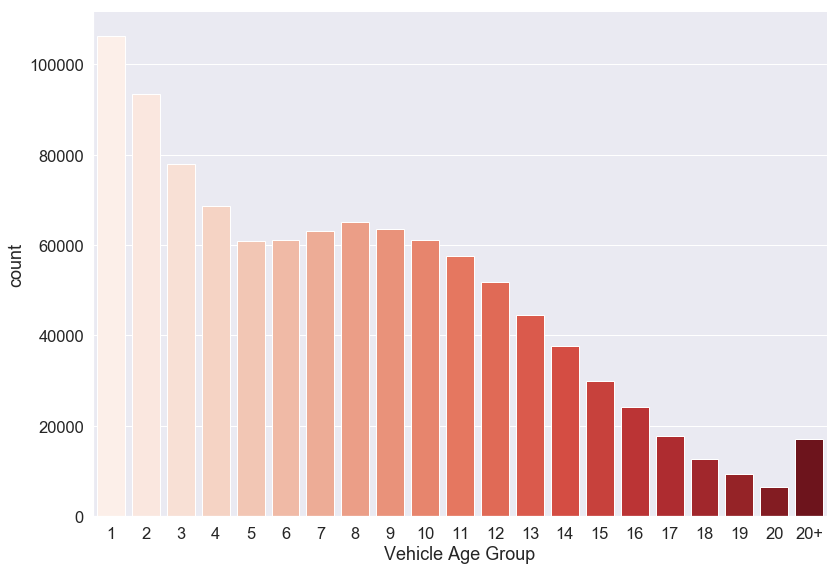

In [148]:
sns.set(rc={'figure.figsize':(12.7,14.27)})
sns.set(font_scale = 1.5)
# sort df by Vehicle Age Group column
df['Vehicle Age Group'] = pd.Categorical(df['Vehicle Age Group'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,'20+'])
df = df.sort_values(['Vehicle Age Group']).reset_index(drop=True)
sns.catplot(x="Vehicle Age Group", kind="count", height=8.27, aspect=11.7/8.27, palette="Reds", data=df);

Interesting observation: one year old cars are involved in about twice as many accidents as 5 - 10 year old ones. The number 
of crashes decreases with age but plateaus at around 5 years but after 9 years decreases with age again.

### Severe/Lethal Injury by age group 

**Injury Severity classes**

In [149]:
df['Injury Severity'].value_counts()
df['Injury Severity'].value_counts() / len(df['Injury Severity']) * 100

Uninjured                     78.026426
Minor                         17.496190
Moderate                       2.296523
Severe                         1.438047
Injured with Unkn Severity     0.618034
Killed                         0.124781
Name: Injury Severity, dtype: float64

**Create age group feature**

In [150]:
def age(x):
    if 15 < x <= 20: return '15-20'
    elif 20 < x <= 25: return '20-25'
    elif 25 < x <= 30: return '25-30'
    elif 30 < x <= 35: return '30-35'
    elif 35 < x <= 40: return '35-40'
    elif 40 < x <= 45: return '40-45'
    elif 45 < x <= 50: return '45-50'
    elif 50 < x <= 55: return '50-55'
    elif 55 < x <= 60: return '55-60'
    elif 60 < x <= 65: return '60-65'
    elif 65 < x <= 70: return '65-70'
    elif x > 70: return '70+'
    else: return 'NaN'
df['Age Group'] = df['Age'].apply(age)

### Number of crashes by age group

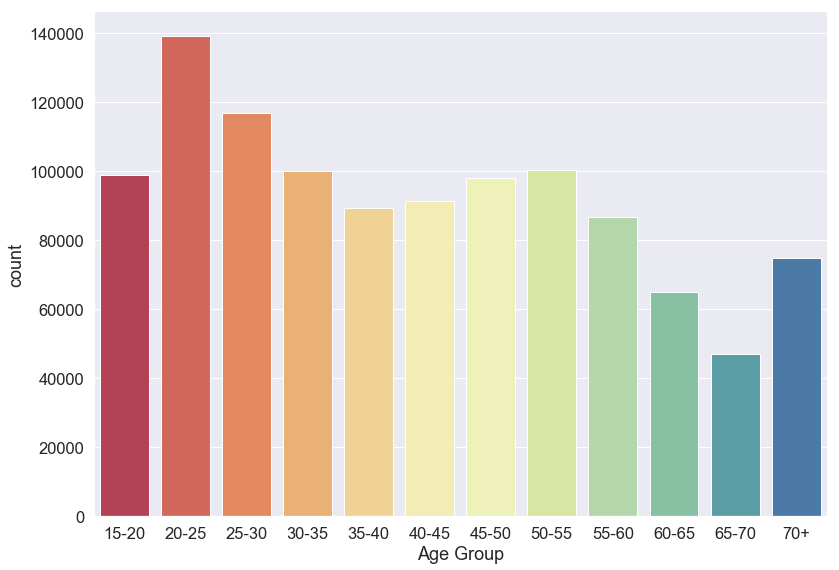

In [151]:
sns.set(rc={'figure.figsize':(12.7,14.27)})
sns.set(font_scale = 1.5)
# sort df by Vehicle Age Group column
df['Age Group'] = pd.Categorical(df['Age Group'], ['15-20','20-25','25-30','30-35','35-40','40-45','45-50','50-55',
                                                   '55-60','60-65','65-70','70+'])
df = df.sort_values(['Age Group']).reset_index(drop=True)
sns.catplot(x="Age Group", kind="count", height=8.27, aspect=11.7/8.27, palette="Spectral", data=df)

Interesting observations: the number of severe/lethal injuries is highest for the 20-25 year range and decreases with age 
and reaches a plateau after about age 30. Also, people less than 20 are involved in as many crashes as middle-aged people.

### Frequency of people killed by age

In [152]:
def killed(x):
    if x == 'Killed':
        return 1
    else:
        return 0

df['Killed'] = df['Injury Severity'].apply(killed)

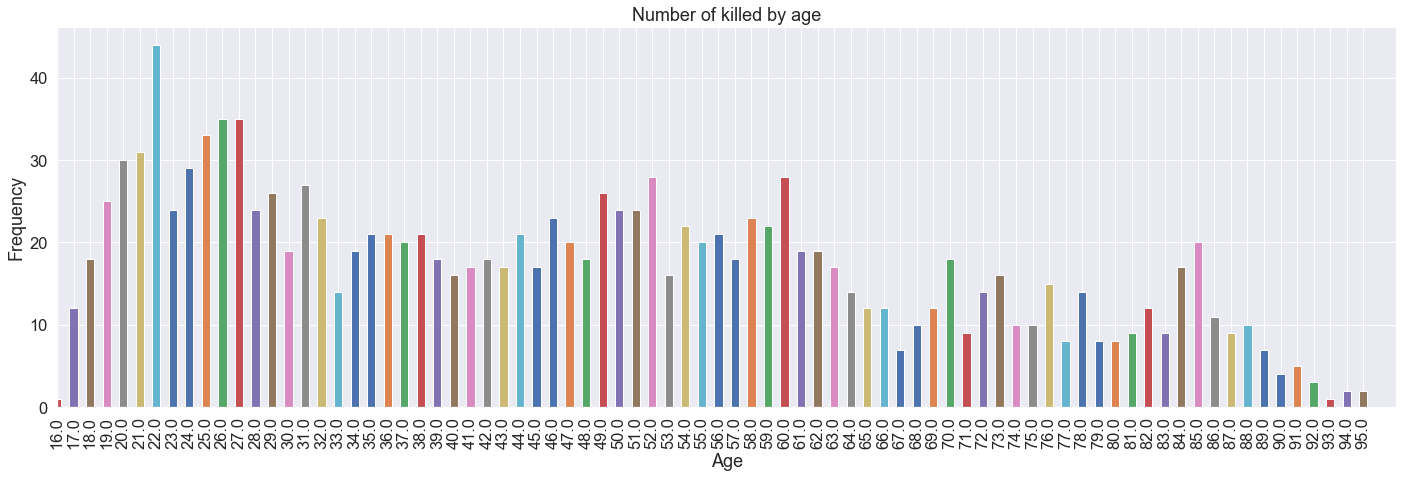

In [153]:
plt.xlim(15,95)
ax = df.groupby(['Age'])['Killed'].agg('sum').plot.bar(title="Number of killed by age", figsize=(24,7))
_ = ax.set_xlim(14,95)
_ = ax.set_xlabel('Age')
_ = ax.set_ylabel('Frequency')

### Building a model to predict injury in a motor vehicle crash

#### Create target variable for predictive model

In [154]:
# Injury includes all severities from minor to lethal
def injury(x):
    if x == 'Uninjured':
        return 0
    else:
        return 1

df['Injured'] = df['Injury Severity'].apply(injury)

In [155]:
df.Injured.value_counts() / len(df.Injured)

0    0.780264
1    0.219736
Name: Injured, dtype: float64

About 22% of motorists suffer an injury of some sort. This provides a relatively good dataset to predict whether 
an injury will be caused in a crash.

#### Convert categorical variables into numeric

In [156]:
for col_name in df.columns:
    if(df[col_name].dtype == 'object'):
        df[col_name]= df[col_name].astype('category')
        df[col_name] = df[col_name].cat.codes

#### Build a heat map to look at possible correlations between features

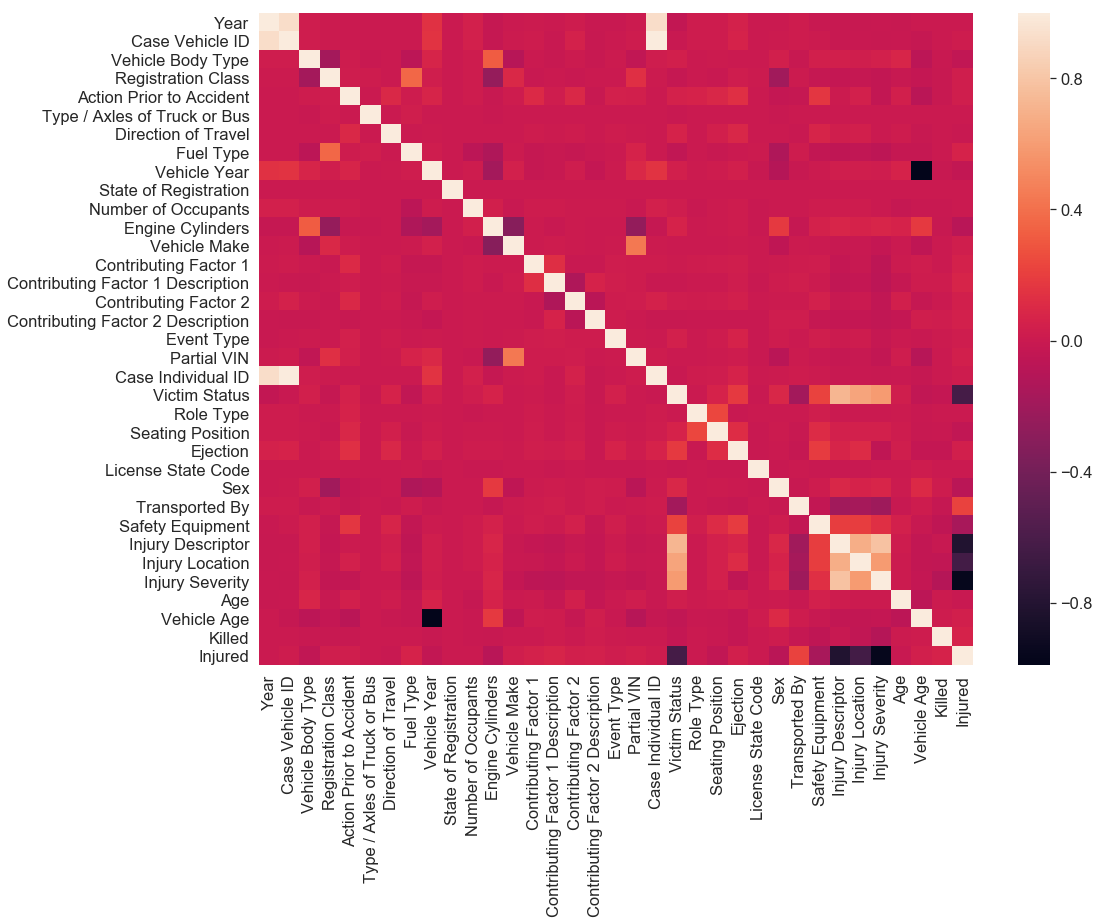

In [157]:
plt.subplots(figsize=(16,12))
heatmap_plot = sns.heatmap(df.corr())
figure = heatmap_plot.get_figure()    
figure.savefig('Correlation Heatmap Figure.png', dpi=400)

We observe several non-negligible correlations between Victim Status and Injury Descriptor, Injury Location and Injury 
Severity which is understandable as the Injury characteristics are closely related to the status of the victim. We will 
drop Victim Status, Injury Descriptor and Injury Severity from the dataset used to build the model. There are some correlation
between Case Individual ID and Vehicle Type but IDs will be dropped from the dataset.

In [158]:
#List column values
list(df.columns.values)

['Year',
 'Case Vehicle ID',
 'Vehicle Body Type',
 'Registration Class',
 'Action Prior to Accident',
 'Type / Axles of Truck or Bus',
 'Direction of Travel',
 'Fuel Type',
 'Vehicle Year',
 'State of Registration',
 'Number of Occupants',
 'Engine Cylinders',
 'Vehicle Make',
 'Contributing Factor 1',
 'Contributing Factor 1 Description',
 'Contributing Factor 2',
 'Contributing Factor 2 Description',
 'Event Type',
 'Partial VIN',
 'Case Individual ID',
 'Victim Status',
 'Role Type',
 'Seating Position',
 'Ejection',
 'License State Code',
 'Sex',
 'Transported By',
 'Safety Equipment',
 'Injury Descriptor',
 'Injury Location',
 'Injury Severity',
 'Age',
 'Vehicle Age',
 'Vehicle Age Group',
 'Age Group',
 'Killed',
 'Injured']

###  Feature Selection

#### Drop IDs, VIN numbers, Codes from the data frame

In [159]:
# Fuel type is also dropped because it would be reasonable to assume that the injury of a victim would not depend on the fuel 
# type used
drop_list = ['Case Vehicle ID','Fuel Type','State of Registration','Partial VIN','Case Individual ID','License State Code']
df.drop(drop_list, axis=1, inplace=True)

In [160]:
df.head()

,Year,Vehicle Body Type,Registration Class,Action Prior to Accident,Type / Axles of Truck or Bus,Direction of Travel,Vehicle Year,Number of Occupants,Engine Cylinders,Vehicle Make,Contributing Factor 1,Contributing Factor 1 Description,Contributing Factor 2,Contributing Factor 2 Description,Event Type,Victim Status,Role Type,Seating Position,Ejection,Sex,Transported By,Safety Equipment,Injury Descriptor,Injury Location,Injury Severity,Age,Vehicle Age,Vehicle Age Group,Age Group,Killed,Injured
0,2016,1,45,4,18,9,2014.0,4.0,4.0,447,1,9,1,25,20,4,0,0,2,1,6,10,14,12,5,15.0,2.0,2,NaN,0,0
1,2016,1,45,4,18,1,2003.0,4.0,5.0,1075,1,9,1,50,19,3,0,0,2,1,6,10,13,11,5,15.0,13.0,13,NaN,0,0
2,2016,39,45,7,18,0,2008.0,1.0,4.0,447,1,9,1,14,19,4,0,0,2,1,6,10,14,12,5,15.0,8.0,8,NaN,0,0
3,2016,1,45,4,18,8,2012.0,2.0,4.0,175,1,9,1,24,19,3,0,0,2,0,6,11,13,11,5,14.0,4.0,4,NaN,0,0
4,2014,27,45,4,18,5,1993.0,2.0,6.0,239,1,14,0,55,20,1,0,0,2,1,2,15,2,4,2,15.0,21.0,20+,NaN,0,1


In [161]:
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split dataset into train and test dataset
    """
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

**Choose sensible features for the dataset**

In [162]:
headers = ['Vehicle Body Type', 'Action Prior to Accident', 'Direction of Travel', 'Number of Occupants', 
           'Contributing Factor 1', 'Contributing Factor 2', 'Engine Cylinders', 'Vehicle Make', 'Event Type', 
           'Seating Position', 'Ejection', 'Sex', 'Safety Equipment', 'Age', 'Vehicle Age', 'Injured']

**Split the data in training and test sets**

In [163]:
# The last element of the headers list is the target and the other elements are the predictors
train_x, test_x, train_y, test_y = split_dataset(df, 0.8, headers[:-1], headers[-1])

In [164]:
# Train and Test dataset size details
print ("Train_x Shape : ", train_x.shape)
print ("Train_y Shape : ", train_y.shape)
print ("Test_x Shape : ", test_x.shape)
print ("Test_y Shape : ", test_y.shape)

Train_x Shape :  (886035, 15)
Train_y Shape :  (886035,)
Test_x Shape :  (221509, 15)
Test_y Shape :  (221509,)


In [165]:
# Function to plot feature imporatance chart
def plot_feature_importance(model, title):
    features = headers[:-1]
    # Calculate feature importances
    importances = model.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    # Rearrange feature names so they match the sorted feature importances
    feature_names = [features[i] for i in indices]
    f, ax = plt.subplots(figsize=(18,5))
    plt.bar(range(train_x.shape[1]), importances[indices])
    # Add feature names as x-axis labels
    plt.xticks(range(train_x.shape[1]), feature_names, rotation=20, fontsize = 10)
    # Create plot title
    plt.title(title)
    plt.show()    

In [166]:
# Draw ROC curve from model
def draw_roc_curve(model, predictions):
    f, ax = plt.subplots(figsize=(7,5))
    y_pred_proba = model.predict_proba(test_x)[::,1]
    fpr, tpr, _ = roc_curve(test_y,  y_pred_proba)
    auc = roc_auc_score(test_y, predictions)
    plt.plot(fpr,tpr,label="ROC Curve, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

### Decision Tree Classifier

In [167]:
dtree_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dtree_classifier.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [168]:
# Predictions on the test data
y_pred_decision_tree = dtree_classifier.predict(test_x)

In [169]:
print("y_pred_decision_tree : \n", y_pred_decision_tree)

y_pred_decision_tree : 
 [0 0 0 ... 0 0 1]


In [170]:
print ("Test Accuracy  : {0:.2f} %".format(accuracy_score(test_y, y_pred_decision_tree)*100))

Test Accuracy  : 70.55 %


In [171]:
#cm_decision = confusion_matrix(test_y, y_pred_decision_tree)
print("Confusion Matrix : \n", confusion_matrix(test_y, y_pred_decision_tree))

Confusion Matrix : 
 [[139156  33711]
 [ 31530  17112]]


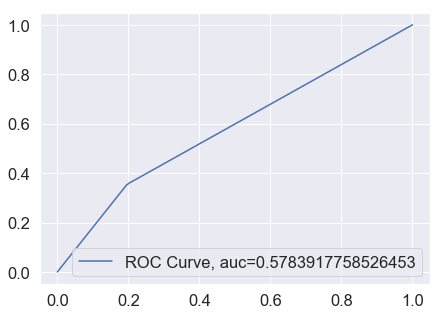

In [172]:
draw_roc_curve(dtree_classifier, y_pred_decision_tree)

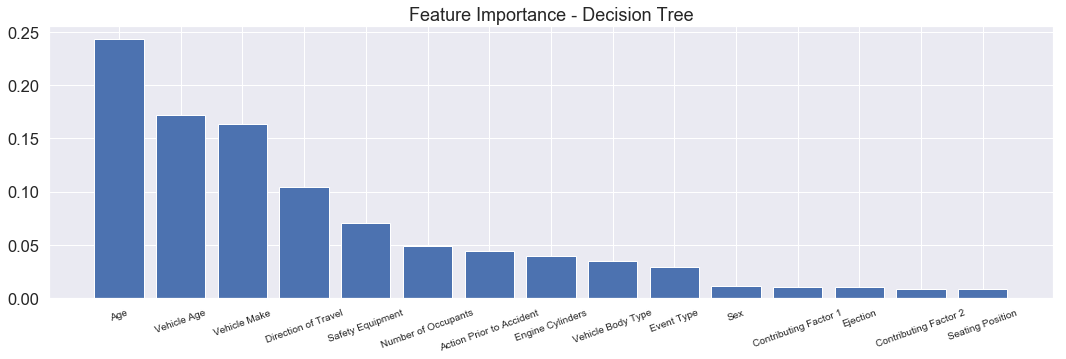

In [173]:
plot_feature_importance(dtree_classifier, 'Feature Importance - Decision Tree')

The accuracy and AUC of the Decision Tree classifier are low and we now try a random forest classifier to get better results.

### Random Forest Classifier

In [174]:
# Create random forest classifier instance
random_forest_classifier = RandomForestClassifier()
random_forest_classifier = random_forest_classifier.fit(train_x, train_y)
print ("Model : ", random_forest_classifier)
rfc_predictions = random_forest_classifier.predict(test_x)

Model :  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [175]:
print ("Test Accuracy  : {0:.2f} %".format(accuracy_score(test_y, rfc_predictions)*100))

Test Accuracy  : 77.39 %


In [176]:
print("Confusion Matrix : \n", confusion_matrix(test_y, rfc_predictions))

Confusion Matrix : 
 [[160363  12504]
 [ 37580  11062]]


#### 5-fold Cross validation

In [177]:
# 5-Fold Cross validation
print(np.mean(cross_val_score(random_forest_classifier, train_x, train_y, cv=5)))

0.7747335037554949


The mean cross-validation value is consistent with the value obtained above without cross-validation.

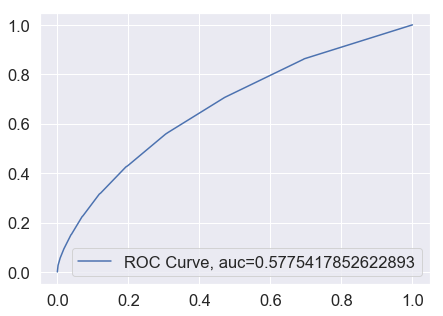

In [178]:
draw_roc_curve(random_forest_classifier, rfc_predictions)

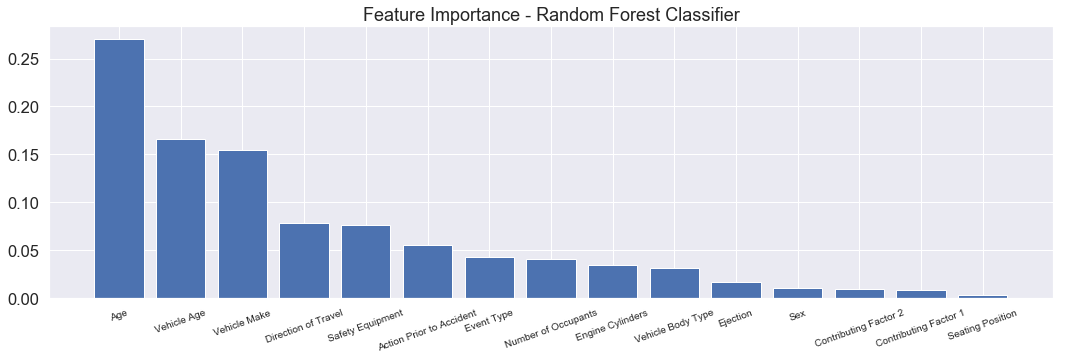

In [179]:
plot_feature_importance(random_forest_classifier, 'Feature Importance - Random Forest Classifier')

The accuracy improves by about 10% with respect to the Decision Tree model. Let us look at a logistic regression model to 
see if we can do better.

### Logistic Regression

In [180]:
# Instantiate a logistic regression model, and fit with training predictors and target
logistic_regressor = LogisticRegression()
logistic_regressor = logistic_regressor.fit(train_x, train_y)

In [181]:
# Check accuracy on test dataset
logistic_regressor.score(test_x, test_y)

0.7840132906563616

In [182]:
# Predict class labels for the test set
predicted = logistic_regressor.predict(test_x)
print(predicted)

[0 0 0 ... 0 0 0]


In [183]:
# generate class probabilities
probs = logistic_regressor.predict_proba(test_x)
print(probs)

[[0.80463845 0.19536155]
 [0.76419038 0.23580962]
 [0.68032051 0.31967949]
 ...
 [0.77423864 0.22576136]
 [0.84890449 0.15109551]
 [0.5319807  0.4680193 ]]


In [184]:
# Generate evaluation metrics
print(accuracy_score(test_y, predicted))
print(roc_auc_score(test_y, probs[:, 1]))

0.7840132906563616
0.6499326943453254


In [185]:
print(confusion_matrix(test_y, predicted))
print(classification_report(test_y, predicted))

[[171108   1759]
 [ 46084   2558]]
              precision    recall  f1-score   support

           0       0.79      0.99      0.88    172867
           1       0.59      0.05      0.10     48642

   micro avg       0.78      0.78      0.78    221509
   macro avg       0.69      0.52      0.49    221509
weighted avg       0.74      0.78      0.71    221509



**Regression Coefficients**

In [186]:
coefficients = pd.concat([pd.DataFrame(train_x.columns),pd.DataFrame(np.transpose(logistic_regressor.coef_))], axis = 1)
coefficients

,0,0
0,Vehicle Body Type,-0.001309
1,Action Prior to Accident,0.017386
2,Direction of Travel,-0.000170
3,Number of Occupants,0.003664
4,Contributing Factor 1,0.591516
5,Contributing Factor 2,0.400991
6,Engine Cylinders,-0.134104
7,Vehicle Make,0.000033
8,Event Type,0.018627
9,Seating Position,-0.666722


The accuracy of the logistic regressor is marginally better than that of the Random Forest classifier. We now try to see whether we can see improved results from the h2o library.

### Apply several ML algorithms from h2o library

In [187]:
h2o.init()          # Start an H2o instance 
h2o.remove_all()    # Start with a clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321.. connected.


H2O cluster uptime:,20 hours 4 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_Michael_j0krlh
H2O cluster total nodes:,1
H2O cluster free memory:,3.040 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


**Convert pandas data frame to h2o frame**

In [188]:
h2o_df = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


**Setting predictors and response variables for h2o models**

In [189]:
# Convert IsBound as factor
h2o_df['Injured'] = h2o_df['Injured'].asfactor()

# Set the predictors and the response columns
predictors = ['Vehicle Body Type', 'Action Prior to Accident', 'Direction of Travel', 'Number of Occupants', 
           'Contributing Factor 1', 'Contributing Factor 2', 'Engine Cylinders', 'Vehicle Make', 'Event Type', 
           'Seating Position', 'Ejection', 'Sex', 'Safety Equipment', 'Age', 'Vehicle Age']
response = 'Injured'

# Split data frame into train and validation datasets
train, valid = h2o_df.split_frame(ratios = [.75], seed = 1234)

In [190]:
# Function to draw feature importance
def draw_feature_importance_h2o(model, color, title):
    scaled_importance = model._model_json['output']['variable_importances']['scaled_importance']
    plt.figure(figsize=(18, 6))  
    plt.bar(range(train_x.shape[1]), scaled_importance, color=color)
    feature_names = model._model_json['output']['variable_importances']['variable']
    plt.xticks(range(train_x.shape[1]), feature_names, rotation=20, fontsize = 10)
    plt.title(title)
    plt.ylabel("Scaled Importance")
    plt.show()

In [191]:
# Function to print metrics of model
def print_metrics(model):
    print('Model Type:', model.type)
    print('logloss:', model.logloss(valid = False))
    print('Accuracy:', model.accuracy(valid = False))
    print('AUC:', model.auc(valid = False))
    print('R2:', model.r2(valid = False))
    print('RMSE:', model.rmse(valid = False))
    print('Error:', model.error(valid = False))
    print('MCC:', model.mcc(valid = False))

### Random Forest Estimator

In [192]:
# Choose binomial double trees to build twice as many trees which could lead to higher accuracy.
dist_random_forest = H2ORandomForestEstimator(binomial_double_trees = True, seed = 1234)
dist_random_forest.train(x = predictors, y = response, training_frame = train, validation_frame = valid)
dist_random_forest.confusion_matrix()
# or specify the validation frame
dist_random_forest.confusion_matrix(valid=True)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2281967656179901: 


,0,1,Error,Rate
0,156446.0,59926.0,0.277,(59926.0/216372.0)
1,23241.0,37262.0,0.3841,(23241.0/60503.0)
Total,179687.0,97188.0,0.3004,(83167.0/276875.0)


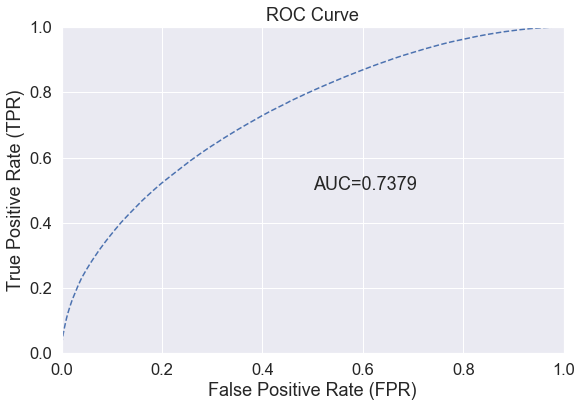

In [193]:
# Model performance
plt.figure(figsize=(9, 6)) 
performance = dist_random_forest.model_performance(test_data=valid)
performance = dist_random_forest.model_performance()  #train=True is the default, so it's not needed
#print (performance)
performance.plot()

In [194]:
print_metrics(dist_random_forest)

Model Type: classifier
logloss: 0.45751718328963287
Accuracy: [[0.47601170417312205, 0.7999566614901225]]
AUC: 0.7379333261993737
R2: 0.14597379159147106
RMSE: 0.3829080672166951
Error: [[0.47601170417312205, 0.20004333850987754]]
MCC: [[0.3107848001228187, 0.30447925414536026]]


The accuracy for the Random Forest estimator on the test data is the second value in the accuracy list above, that is 
0.8004825026574965. We see a small improvement in the accuracy compared  and we hit the 80% mark. 

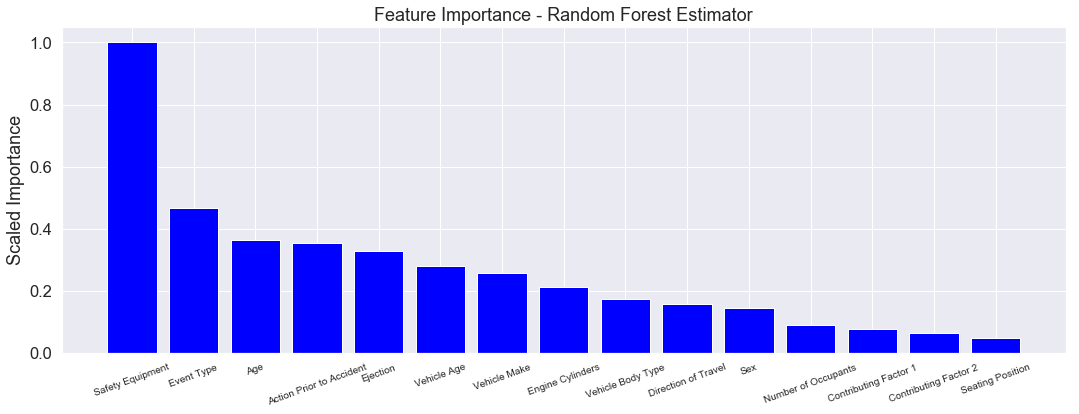

In [195]:
draw_feature_importance_h2o(dist_random_forest, 'blue', 'Feature Importance - Random Forest Estimator')

### Gradient Boosting Estimator

In [196]:
# Build GBE model with ntrees and max_depth parameters
grad_boosting_estimator = H2OGradientBoostingEstimator(ntrees=100, max_depth=10)
grad_boosting_estimator.train(x = predictors, y = response, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


gbm prediction progress: |████████████████████████████████████████████████| 100%


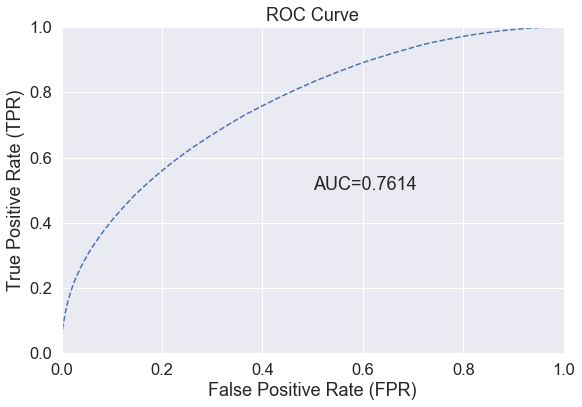

In [198]:
# Get prediction and model performance parameters
plt.figure(figsize=(9, 6)) 
prediction = grad_boosting_estimator.predict(valid)
performance = grad_boosting_estimator.model_performance()
#performance
performance.plot()

In [199]:
print_metrics(grad_boosting_estimator)

Model Type: classifier
logloss: 0.4411654698456554
Accuracy: [[0.4745551918436205, 0.8084895325460171]]
AUC: 0.7613897593024276
R2: 0.17989224262311532
RMSE: 0.37522725560374603
Error: [[0.4745551918436205, 0.19151046745398292]]
MCC: [[0.34379049420088603, 0.3406977676552383]]


In [ ]:
The accuracy of the gradient boosting estimator is 0.808489, close to 81%. This is a small improvement from the Random
Forest estimator.

#### Cross validation with 5 folds

In [200]:
# Set the number of folds
folds = 5
# Initialize the estimator with the number of folds
gbm_5folds = H2OGradientBoostingEstimator(nfolds = folds, seed = 1234)
# Train the model
gbm_5folds.train(x = predictors, y = response, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [201]:
print_metrics(gbm_5folds)

Model Type: classifier
logloss: 0.4592129329523582
Accuracy: [[0.453266197832945, 0.8003298542140682]]
AUC: 0.7369270189037265
R2: 0.1435503116219089
RMSE: 0.38345097364425623
Error: [[0.453266197832945, 0.19967014578593179]]
MCC: [[0.3032382510348745, 0.30604927080182703]]


We find that the mean value of the testing accuracy with 5-folds cross-validation is slightly lower than without 
cross-validation.

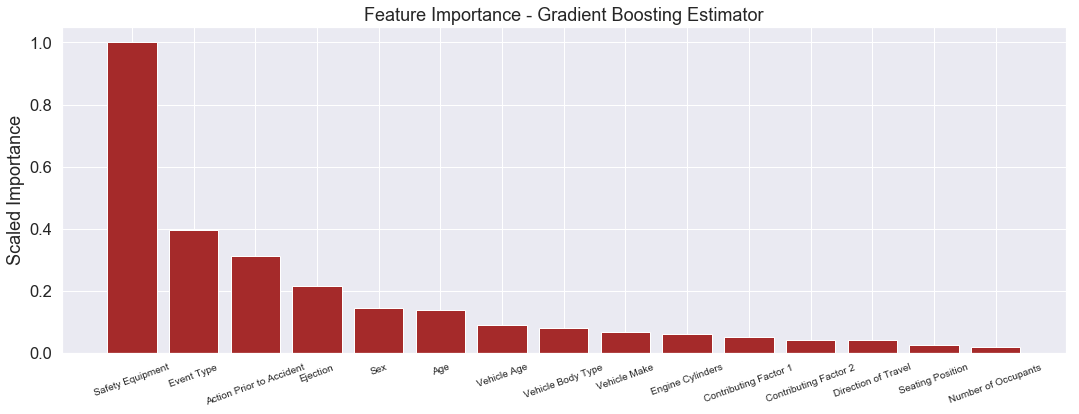

In [203]:
draw_feature_importance_h2o(grad_boosting_estimator, 'brown', 'Feature Importance - Gradient Boosting Estimator')

We notice that the order of the feature importances from the algorithms from the h2o package are markedly different than those 
from scikit-learn. Safety Equipment is shown as the most important feature which makes sense considering it is one of the most
prominent ways to reduce injuries. 

### Deep Learning Estimator

In [80]:
# Initialize and train the DL estimator:
dl_estimator = H2ODeepLearningEstimator(epochs=1000, seed=1,  balance_classes = True)
dl_estimator.train(x = predictors, y = response, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


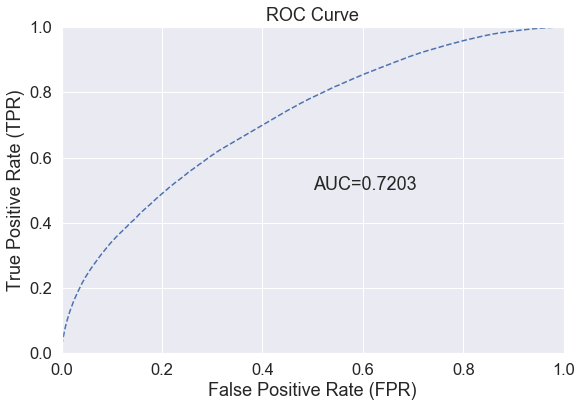

In [81]:
# Performance plot
plt.figure(figsize=(9, 6)) 
perf = dl_estimator.model_performance(valid)
perf.plot()

In [82]:
print_metrics(dl_estimator)

Model Type: classifier
logloss: 0.7446397537076309
Accuracy: [[0.22774020113004909, 0.6582744551696686]]
AUC: 0.7243502871855813
R2: -0.06981305929961445
RMSE: 0.517152690937302
Error: [[0.22774020113004909, 0.34172554483033135]]
MCC: [[0.25162626321361864, 0.318608240765022]]


The Deep Learning estimator performs poorly as can be seen from the accuracy score of 0.6583. One possible reason is the 
dataset size being too small for such an analysis.

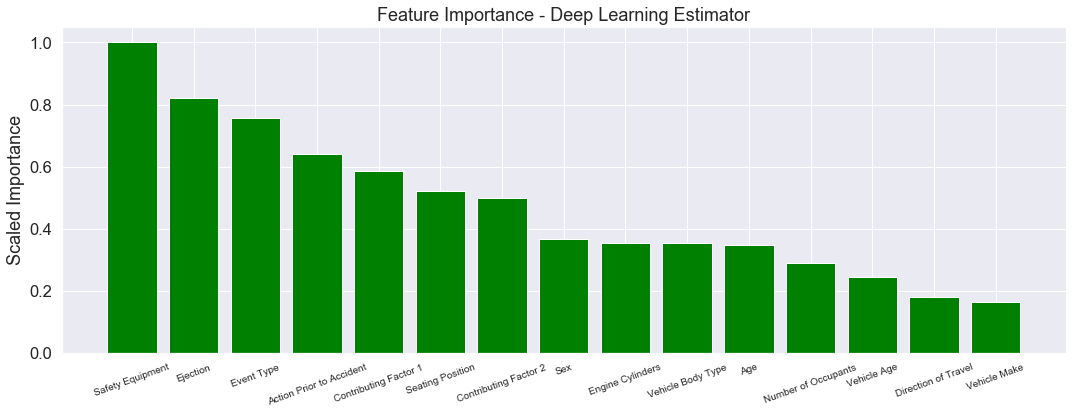

In [76]:
draw_feature_importance_h2o(dl_estimator, 'green', 'Feature Importance - Deep Learning Estimator')

### Summary and Outlook

The analysis of crash data revealed some interesting observations: cars that are newer are involved in more crashes than older
cars. Also, there is a slow decrease of people killed in crashes with age of the victim. From the current analysis, 
predictive models on the injury of the vehicle occupant give accuracies that vary from about 0.7 (decision tree classifier) to 
slightly above 0.8 (gradient boosting model). Feature importance charts show differences between those obtained using 
scikit-learn and h2o.

In subsequent analyses, one could look into other target variables, for instance predicting if somebody will be killed instead 
of just injured in the crash. Such an analysis would need to include strategies to balance the target classes as the dataset 
will be highly imbalanced due to the very small percentage of persons killed in crashes.